In [1]:
import matplotlib.pyplot as plt

from skimage.color import rgb2gray, rgba2rgb
import skimage.io as skio
from skimage.util.shape import view_as_windows
from skimage.transform import resize

import numpy as np
import pandas as pd 
from scipy import stats  
from einops import rearrange, reduce, repeat

import itertools
import os
import glob
import warnings
import tqdm

from utils import default_paths

"""
Code to perform curvature analysis on images corresponding to each sketch token 
feature (clusters in curvature space).
Original version from Xiaomin Yue, related to paper:
"Curvature processing in human visual cortical areas" (2020), Neuroimage.
Modified for this project by MMH.
Saves out a csv file listing the approx curvature params of each feature.
"""

class CurvRectValues:  
    def __init__(self, scales, orients, bends, proc_cluster_ims=False):
        self.files           = []
        self.image_size      = 128 
        self.randstate       = 49
        self.file_block_size = 20
        self.images          = []
        self.fft_images      = []
        self.cg_parameters   = {'kA':0.3,'bend':0.01,'orientation':45*np.pi/180}
        self.curv_values     = []
        self.rect_values     = []
        self.curv_max        = []
        self.rect_max        = []
        self.curv_unique     = []
        self.rect_unique     = []
        self.proc_cluster_ims= proc_cluster_ims
        self.__generate_kernels__(scales, orients, bends)
        
    
    def __bananakernel__(self):
        """
        input: cg_parameters is a dictionary, including kA, bA, alphaA, mA, sigmaXbend, sigmaYbend, 
                                               xA_half, yA_half, xA_shift, yA_shift
                                               
        the function is used to generate banana wavelet kernels.  The kernels
        can be used to filter a image to quantify curvatures.

        kA:          length of the wave vector K
        bA:          bending value b
        alphaA:      direction of the wave vector
        mA:          magnitude value m
        xA_half:     x-size
        yA_half:     y-size
        xA_shift:    center shift in x direction
        yA_shift:    center shift in y direction

        for references:
        preFactorA:  pre-factor p
        DCPartRealA: real dc-part
        DCPartImagA: imaginary dc-part
        gaussPartA:  Gaussian part    

        filter requency: (cycle/object) = xA*kA/(2*pi*mA)
        kernel size: 2*4*sigmaYbend*mA*(1/kA)

        return SpaceKernel, FreqKernel

        last updated 5/23/2021
        last updated 3/23/3021
        """
        kA         = self.cg_parameters['kA']
        bA         = self.cg_parameters['bend']    
        alphaA     = self.cg_parameters.get('orientation',45*np.pi/180)
        mA         = self.cg_parameters.get('mA',3)
        sigmaXbend = self.cg_parameters.get('sigmaXbend',2)
        sigmaYbend = self.cg_parameters.get('sigmaYbend',2)
        xA_half    = self.cg_parameters.get('xA_half',self.image_size/2)
        yA_half    = self.cg_parameters.get('yA_half',self.image_size/2)
        xA_shift   = self.cg_parameters.get('x_shift',0)
        yA_shift   = self.cg_parameters.get('y_shift',0)
        
        if isinstance(bA, complex):
            print('bA has to be real number. However your input is a complex number')
            bA = np.real(bA)

        if any(x<=0 for x in np.array([kA, mA])) or any(np.isnan(np.array([kA, bA, alphaA, mA]))):     
            out_ranage_value = 10**-20
            SpaceKernel = np.ones((2*xA_half,2*yA_half))*out_ranage_value
            FreqKernel   = np.ones((2*xA_half,2*yA_half))*out_ranage_value
            return SpaceKernel, FreqKernel

        kernel_size = 2*xA_half
        if kernel_size%2 !=0:
            kernel_size = kernel_size + 1
        [xA, yA] = np.meshgrid(np.arange(-kernel_size/2, kernel_size/2,1),np.arange(-kernel_size/2, kernel_size/2,1)) 
        xA = xA - xA_shift
        yA = yA - yA_shift

        xRotL = np.cos(alphaA)*xA + np.sin(alphaA)*yA 
        yRotL = np.cos(alphaA)*yA - np.sin(alphaA)*xA

        if is_curv:
            xRotBendL = xRotL + bA * (yRotL)**2
        else:
            # if is_curved
            xRotBendL = xRotL + bA*24* np.abs(yRotL)

        xRotBendL = xRotL + bA * (yRotL)**2
        yRotBendL = yRotL

        """make the DC free""" 
        tmpgaussPartA = np.exp(-0.5*(kA)**2*((xRotBendL/sigmaXbend)**2 + (yRotBendL/(mA*sigmaYbend))**2))
        tmprealteilL  = 1*tmpgaussPartA*(np.cos(kA*xRotBendL) - 0)
        tmpimagteilL  = 1*tmpgaussPartA*(np.sin(kA*xRotBendL) - 0)

        numeratorRealL = np.sum(tmprealteilL)
        numeratorImagL = np.sum(tmpimagteilL)
        denominatorL   = np.sum(tmpgaussPartA)

        DCValueAnalysis = np.exp(-0.5 * sigmaXbend * sigmaXbend)
        if denominatorL==0:
            DCPartRealA = DCValueAnalysis
            DCPartImagA = 0
        else:    
            DCPartRealA = numeratorRealL/denominatorL
            DCPartImagA = numeratorImagL/denominatorL
            if DCPartRealA < DCValueAnalysis:
                DCPartRealA = DCValueAnalysis
                DCPartImagA = 0

        """generate a space kernel""" 
        preFactorA = kA**2
        gaussPartA = np.exp(-0.5*(kA)**2*((xRotBendL/sigmaXbend)**2 + (yRotBendL/(mA*sigmaYbend))**2))
        realteilL  = preFactorA*gaussPartA*(np.cos(kA*xRotBendL) - DCPartRealA)
        imagteilL  = preFactorA*gaussPartA*(np.sin(kA*xRotBendL) - DCPartImagA)

        """normalize the kernel"""  
        normRealL   = np.sqrt(np.sum(realteilL**2))
        normImagL   = np.sqrt(np.sum(imagteilL**2))
        normFactorL = kA**2

        total_std = normRealL + normImagL
        if total_std == 0:
            total_std = 10**20
        norm_realteilL = realteilL*normFactorL/(0.5*total_std)
        norm_imagteilL = imagteilL*normFactorL/(0.5*total_std)
        
        space_kernel = norm_realteilL + norm_imagteilL*1j
        freq_kernel = np.fft.ifft2(space_kernel)
        return space_kernel, freq_kernel
                                  
        
    def __generate_kernels__(self, scales, orients, bends):
        kA_scales = scales
        alphaA = orients
        all_kA = [2*np.pi/((np.sqrt(2))**x) for x in kA_scales]
       
        curv_freq_kernels,rect_freq_kernels,curv_space,rect_space = [],[],[],[]
        
        curv_kernel_pars = np.zeros((len(all_kA)*(len(bends)-1)*len(alphaA), 3))
        rect_kernel_pars = np.zeros((len(all_kA)*(len(bends)-1)*len(alphaA), 3))
        linear_kernel_pars = np.zeros((len(all_kA)*(1)*len(alphaA), 3))
        
        ci=-1; ri=-1
        for kA, bA, orien in itertools.product(all_kA, bends, alphaA):
            self.cg_parameters['kA']          = kA
            self.cg_parameters['bend']        = bA/8
            self.cg_parameters['orientation'] = orien
            neuron, Freq_kernel = self.__bananakernel__()
            if bA == 0:
                rect_freq_kernels.append(Freq_kernel)
                rect_space.append(neuron.real) 
                ri+=1
                rect_kernel_pars[ri,:] = [kA, bA/8, orien]
            else:
                curv_freq_kernels.append(Freq_kernel)
                curv_space.append(neuron.real)
                ci+=1
                curv_kernel_pars[ci,:] = [kA, bA/8, orien]


        self.kernels = {'curv_freq':curv_freq_kernels, 'curv_space':curv_space,
                        'rect_freq':rect_freq_kernels, 'rect_space':rect_space}
        self.rect_kernel_pars = rect_kernel_pars
        self.curv_kernel_pars = curv_kernel_pars
        
    
    def __patchnorm__(self,image):
        """ make sure it is gray scale image in range from 0 - 255 """ 
        if np.max(image) <=1:
            image = 255*image/np.max(image)
        orig_size = image.shape
        
        if image.shape[0]%3 == 0:
            patch_size = 3
        else:
            patch_size = 4
        self.patch_size = patch_size
        
        """create patches with the patch_size"""
        patches = view_as_windows(image, (patch_size,patch_size), patch_size)

        """ caculate norm of the local patches """ 
        local_norm = np.sqrt(np.einsum('ijkl->ij',patches**2))
        local_norm[local_norm<1] = 1

        """normalize local patches """ 
        normed_patches = patches/local_norm[:,:,np.newaxis,np.newaxis]

        """reshape normalized local patch to original shape """ 
#         local_normed_image = normed_patches.transpose(0,2,1,3).reshape(-1,normed_patches.shape[1]*normed_patches.shape[3])
        local_normed_image = rearrange(normed_patches,'h w c d -> (h c) (w d)')
        
        return {'local_norm':local_norm, 'local_normed_image':local_normed_image, 
                'total_local_norm':np.sqrt(local_norm.sum())}

    
    def process_images(self, files, save_filename):
        images_list, fft_images_list = [],[]
        self.files = files
        self.curv_values     = []
        self.rect_values     = []
        self.curv_max        = []
        self.rect_max        = []
        self.curv_unique     = []
        self.rect_unique     = []    
        folder_name = os.path.dirname(files[0])
        print(f'processing {len(files)} images...')
        best_kernel_each_image = []
        for i in tqdm.tqdm(range(0, len(files), self.file_block_size)):
            block_files   = files[i:i + self.file_block_size]
            _, fft_images = self.__read_images__(block_files)
            self.__calculate_curv_rect_values__(fft_images)
            bk = self.__get_best_kernel__(fft_images)
            best_kernel_each_image.extend(bk)
            
        self.curv_max    = np.dstack(self.curv_max)
        self.curv_unique = np.dstack(self.curv_unique)
        
        self.rect_max    = np.dstack(self.rect_max)
        self.rect_unique = np.dstack(self.rect_unique)
        
        self.best_kernel_pars = self.all_kernel_pars[best_kernel_each_image,:]
        
        df = pd.DataFrame({'files':self.files, 
                           'curv_values':self.curv_values, 
                           'rect_values':self.rect_values,
                           'best_scale': self.best_kernel_pars[:,0],
                           'best_bend': self.best_kernel_pars[:,1],
                           'best_orient': self.best_kernel_pars[:,2]})    
        df.to_csv(save_filename, index=False)
        
        
    def __read_images__(self,file_block):  
        images_list,fft_images_list = [],[]    
        for image_name in file_block:
            orig_image = skio.imread(image_name)
            image = resize(orig_image, (self.image_size,self.image_size))

            if not self.proc_cluster_ims:
                image = rgb2gray(image)*255            
                patch_processed_image = self.__patchnorm__(image)
                output_image          = patch_processed_image['local_normed_image']
            else:
                output_image = image
                
            fft_image = np.fft.fft2(output_image)
            images_list.append(output_image)
            fft_images_list.append(fft_image)  
            
        self.images.append(images_list) 
        self.fft_images.append(fft_images_list) 
        return images_list, fft_images_list

    def __get_max_image__(self,fft_image_list,kernel_list):
        """image x, image y, kernel dimension, all images (4D array)"""
        all_kernels = np.dstack(kernel_list)
        
        """calculate kernel norm for normalization"""
        all_kernels_power =  np.einsum('ijk,ijk->k',np.abs(all_kernels),np.abs(all_kernels))
        all_kernels_power =  np.sqrt(all_kernels_power)

        """stack fft image list to a 3d array"""
        fft_images        = np.dstack(fft_image_list)
        all_conved_images = np.abs(np.fft.ifft2(fft_images[:,:,np.newaxis,:]*all_kernels[:,:,:,np.newaxis],axes=(0,1)))
        all_conved_images = np.power(all_conved_images,1/2) ## power correction
        all_conved_images = all_conved_images/all_kernels_power[np.newaxis, np.newaxis,:,np.newaxis]
    
        max_images = np.max(all_conved_images,axis=2)
        return max_images  
 
    
    def __calculate_curv_rect_values__(self, fft_image_list):
        curv_max_response = self.__get_max_image__(fft_image_list, self.kernels['curv_freq'])
        rect_max_response = self.__get_max_image__(fft_image_list, self.kernels['rect_freq'])
        
        x, y,_ = curv_max_response.shape        
        self.curv_max.append(curv_max_response) 
        self.rect_max.append(rect_max_response) 
        
        curv_unique = np.where(curv_max_response>rect_max_response, curv_max_response, 0)
        curv_values = np.einsum('ijk->k',curv_unique)
        self.curv_unique.append(curv_unique)
        
        rect_unique = np.where(rect_max_response>curv_max_response, rect_max_response, 0)
        rect_values = np.einsum('ijk->k',rect_unique)
        self.rect_unique.append(rect_unique)
        
        self.curv_values.extend(curv_values/(2*(x/2)**2))
        self.rect_values.extend(rect_values/(2*(x/2)**2))
        
        
    def __get_best_kernel__(self,fft_image_list):
                
        rect_kernel_list = self.kernels['rect_freq']
        rect_spat_kernel_list = self.kernels['rect_space']
        curv_kernel_list = self.kernels['curv_freq']
        curv_spat_kernel_list = self.kernels['curv_space']

        curv_kernel_pars = self.curv_kernel_pars
        rect_kernel_pars = self.rect_kernel_pars
        self.all_kernel_pars = np.concatenate([rect_kernel_pars, curv_kernel_pars], axis=0)

        """image x, image y, kernel dimension, all images (4D array)"""
        all_kernels = np.concatenate([np.dstack(rect_kernel_list), np.dstack(curv_kernel_list)], axis=2)
        all_spat_kernels = np.concatenate([np.dstack(rect_spat_kernel_list), np.dstack(curv_spat_kernel_list)], axis=2)
        
        """calculate kernel norm for normalization"""
        all_kernels_power =  np.einsum('ijk,ijk->k',np.abs(all_kernels),np.abs(all_kernels))
        all_kernels_power =  np.sqrt(all_kernels_power)

        """stack fft image list to a 3d array"""
        fft_images        = np.dstack(fft_image_list)
        all_conved_images = np.abs(np.fft.ifft2(fft_images[:,:,np.newaxis,:]*all_kernels[:,:,:,np.newaxis],axes=(0,1)))
        all_conved_images = np.power(all_conved_images,1/2) ## power correction
        all_conved_images = all_conved_images/all_kernels_power[np.newaxis, np.newaxis,:,np.newaxis]
    
        # take max of each convolved image, and choose which kernel gave the biggest max activation.
        max_each_kernel = np.max(np.max(all_conved_images, 0),0)
        best_kernel_each_image = np.argmax(max_each_kernel, axis=0)
            
        return best_kernel_each_image
 
        
    def show_kernel_example(self):
        fig,ax = plt.subplots(2,2,figsize=(8,6))
        ax = ax.flat
        ax[0].imshow(self.kernels['curv_space'][100])
        ax[0].set(title='curvilinear kernel')
        ax[1].imshow((np.log(np.abs(self.kernels['curv_freq'][100]))))
        ax[1].set(title='power of the curvilinear kernel')
                                
        ax[2].imshow(self.kernels['rect_space'][15])
        ax[2].set(title='rectilinear kernel')
        ax[3].imshow((np.log(np.abs(self.kernels['rect_freq'][15]))))
        ax[3].set(title='power of the curvilinear kernel')
        
        plt.tight_layout()
        plt.show()

    def show_curv_rect_example(self):
        fig, ax = plt.subplots(2,2,figsize=(8,6))
        ax = ax.flat
        ax[0].imshow(np.fft.fftshift(self.curv_max[:,:,0]))
        ax[0].set(title='a max curvilinear image')
        
        ax[1].imshow(np.fft.fftshift(self.rect_max[:,:,0]))
        ax[1].set(title='a max rectilinear image')
        
        ax[2].imshow(np.fft.fftshift(self.curv_unique[:,:,0]))
        ax[2].set(title='a unique curvilinear image')
        
        ax[3].imshow(np.fft.fftshift(self.rect_unique[:,:,0]))
        ax[3].set(title='a unique rectilinear image')
        plt.tight_layout()
        plt.show()
                               
            
    def show_correlation(self):
        tmp_corr = stats.pearsonr(self.curv_values, self.rect_values)
        fig,ax = plt.subplots(1,1)
        ax.scatter(self.curv_values,self.rect_values)
        ax.set(xlabel='curvilinear values',
               ylabel='rectilinear values',
               title=f'correlation:{tmp_corr[0]:.3f}')
        
        plt.tight_layout()
        plt.show()

In [8]:
image_size = 128
# kA         = 0.10
# bA         = 1.0

bA         = 0.10
# bA = 0.20
alphaA     = 45*np.pi/180
mA         = 3
sigmaXbend = 2
sigmaYbend = 2
xA_half    = image_size/2
yA_half    = image_size/2
xA_shift   = 0
yA_shift   = 0

In [15]:
bA = 0.10
kA = 2
is_curv = True
alphaA     = 0*np.pi/180


kernel_size = 2*xA_half
if kernel_size%2 !=0:
    kernel_size = kernel_size + 1
[xA, yA] = np.meshgrid(np.arange(-kernel_size/2, kernel_size/2,1),np.arange(-kernel_size/2, kernel_size/2,1)) 
xA = xA - xA_shift
yA = yA - yA_shift

xRotL = np.cos(alphaA)*xA + np.sin(alphaA)*yA 
yRotL = np.cos(alphaA)*yA - np.sin(alphaA)*xA

if is_curv:
    xRotBendL = xRotL + bA * (yRotL)**2
else:
    xRotBendL = xRotL + bA*24* np.abs(yRotL)
    
yRotBendL = yRotL

"""make the DC free""" 
tmpgaussPartA = np.exp(-0.5*(kA)**2*((xRotBendL/sigmaXbend)**2 + (yRotBendL/(mA*sigmaYbend))**2))
tmprealteilL  = 1*tmpgaussPartA*(np.cos(kA*xRotBendL) - 0)
tmpimagteilL  = 1*tmpgaussPartA*(np.sin(kA*xRotBendL) - 0)

numeratorRealL = np.sum(tmprealteilL)
numeratorImagL = np.sum(tmpimagteilL)
denominatorL   = np.sum(tmpgaussPartA)

DCValueAnalysis = np.exp(-0.5 * sigmaXbend * sigmaXbend)
if denominatorL==0:
    DCPartRealA = DCValueAnalysis
    DCPartImagA = 0
else:    
    DCPartRealA = numeratorRealL/denominatorL
    DCPartImagA = numeratorImagL/denominatorL
    if DCPartRealA < DCValueAnalysis:
        DCPartRealA = DCValueAnalysis
        DCPartImagA = 0

"""generate a space kernel""" 
preFactorA = kA**2
gaussPartA = np.exp(-0.5*(kA)**2*((xRotBendL/sigmaXbend)**2 + (yRotBendL/(mA*sigmaYbend))**2))
realteilL  = preFactorA*gaussPartA*(np.cos(kA*xRotBendL) - DCPartRealA)
imagteilL  = preFactorA*gaussPartA*(np.sin(kA*xRotBendL) - DCPartImagA)

"""normalize the kernel"""  
normRealL   = np.sqrt(np.sum(realteilL**2))
normImagL   = np.sqrt(np.sum(imagteilL**2))
normFactorL = kA**2

total_std = normRealL + normImagL
if total_std == 0:
    total_std = 10**20
norm_realteilL = realteilL*normFactorL/(0.5*total_std)
norm_imagteilL = imagteilL*normFactorL/(0.5*total_std)

space_kernel = norm_realteilL + norm_imagteilL*1j
freq_kernel = np.fft.ifft2(space_kernel)

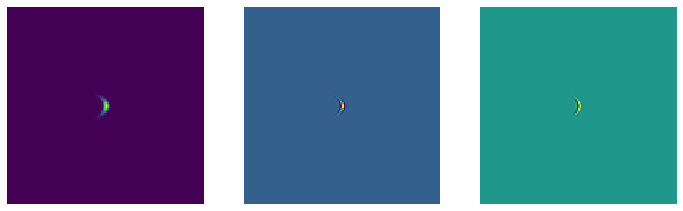

In [16]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.pcolormesh(np.abs(space_kernel))
plt.axis('off')
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(1,3,2)
plt.pcolormesh(np.real(space_kernel))
plt.axis('off')
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(1,3,3)
plt.pcolormesh(np.imag(space_kernel))
plt.axis('off')
plt.axis('square')
plt.gca().invert_yaxis()

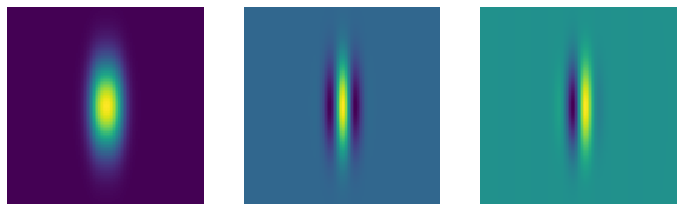

In [341]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.pcolormesh(np.abs(space_kernel))
plt.axis('off')
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(1,3,2)
plt.pcolormesh(np.real(space_kernel))
plt.axis('off')
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(1,3,3)
plt.pcolormesh(np.imag(space_kernel))
plt.axis('off')
plt.axis('square')
plt.gca().invert_yaxis()

In [253]:
if isinstance(bA, complex):
    print('bA has to be real number. However your input is a complex number')
    bA = np.real(bA)

# if any(x<=0 for x in np.array([kA, mA])) or any(np.isnan(np.array([kA, bA, alphaA, mA]))):     
#     out_ranage_value = 10**-20
#     SpaceKernel = np.ones((2*xA_half,2*yA_half))*out_ranage_value
#     FreqKernel   = np.ones((2*xA_half,2*yA_half))*out_ranage_value
#     return SpaceKernel, FreqKernel

kernel_size = 2*xA_half
if kernel_size%2 !=0:
    kernel_size = kernel_size + 1
[xA, yA] = np.meshgrid(np.arange(-kernel_size/2, kernel_size/2,1),np.arange(-kernel_size/2, kernel_size/2,1)) 
xA = xA - xA_shift
yA = yA - yA_shift

xRotL = np.cos(alphaA)*xA + np.sin(alphaA)*yA 
yRotL = np.cos(alphaA)*yA - np.sin(alphaA)*xA

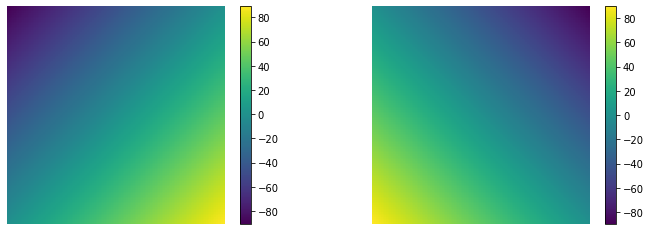

In [242]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.pcolormesh(xRotL)
plt.axis('off')
plt.axis('square')
plt.gca().invert_yaxis()
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolormesh(yRotL)
plt.axis('off')
plt.axis('square')
plt.gca().invert_yaxis()
plt.colorbar()

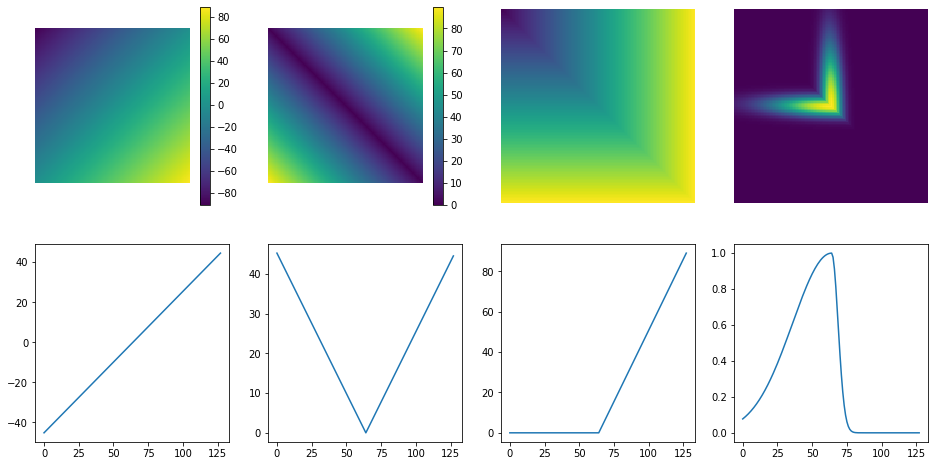

In [299]:

# xRotBendL = xRotL + bA * (yRotL)**2
xRotBendL = xRotL + 1.0 * np.abs(yRotL)
yRotBendL = yRotL

tmpgaussPartA = np.exp(-0.5*(kA)**2*((xRotBendL/sigmaXbend)**2 + (yRotBendL/(mA*sigmaYbend))**2))

plt.figure(figsize=(16,8));
plt.subplot(2,4,1)
plt.pcolormesh(xRotL)
plt.axis('off')
plt.axis('square')
plt.gca().invert_yaxis()
plt.colorbar()

plt.subplot(2,4,2)
plt.pcolormesh(np.abs(yRotL))
plt.axis('off')
plt.axis('square')
plt.gca().invert_yaxis()
plt.colorbar()

plt.subplot(2,4,3)
plt.pcolormesh(xRotBendL)
plt.axis('off')
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(2,4,4)
plt.pcolormesh(tmpgaussPartA)
plt.axis('off')
plt.axis('square')
plt.gca().invert_yaxis()


xpos = 64

plt.subplot(2,4,5)
plt.plot(xRotL[:,xpos])


plt.subplot(2,4,6)
plt.plot(np.abs(yRotL[:,xpos]))

plt.subplot(2,4,7)
plt.plot(xRotBendL[:,xpos])

plt.subplot(2,4,8)
plt.plot(tmpgaussPartA[:,xpos])


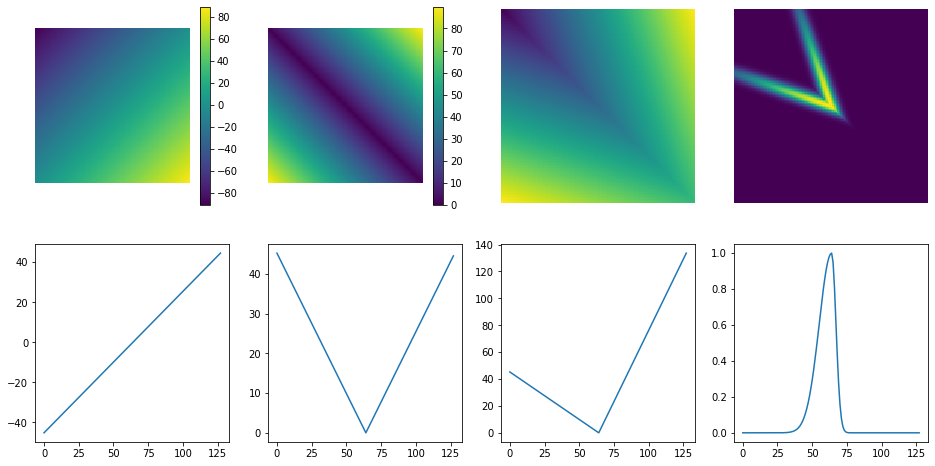

In [276]:

# xRotBendL = xRotL + bA * (yRotL)**2
xRotBendL = xRotL + 2.0 * np.abs(yRotL)
yRotBendL = yRotL


# ang = 90/180*np.pi
# adj = ang/2
# xRot1 = np.cos(alphaA-adj)*xA + np.sin(alphaA-adj)*yA 
# xRot2 = np.cos(alphaA+adj)*xA + np.sin(alphaA+adj)*yA 
# xRotBendL = np.abs(xRot1)+np.abs(xRot2)
# # xRotBendL = np.abs(np.maximum(xRot1,0))+np.abs(np.minimum(xRot2,0))
# # xRotBendL = np.abs(xRot1)+np.abs(xRot2) + 10*np.maximum(xRot1, 0) + 10*np.maximum(xRot2, 0)
# # xRotBendL = np.minimum(xRot1,0)+np.minimum(xRot2,0)
# yRotBendL = yRotL

tmpgaussPartA = np.exp(-0.5*(kA)**2*((xRotBendL/sigmaXbend)**2 + (yRotBendL/(mA*sigmaYbend))**2))

plt.figure(figsize=(16,8));
plt.subplot(2,4,1)
plt.pcolormesh(xRotL)
plt.axis('off')
plt.axis('square')
plt.gca().invert_yaxis()
plt.colorbar()

plt.subplot(2,4,2)
plt.pcolormesh(np.abs(yRotL))
plt.axis('off')
plt.axis('square')
plt.gca().invert_yaxis()
plt.colorbar()

plt.subplot(2,4,3)
plt.pcolormesh(xRotBendL)
plt.axis('off')
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(2,4,4)
plt.pcolormesh(tmpgaussPartA)
plt.axis('off')
plt.axis('square')
plt.gca().invert_yaxis()


xpos = 64

plt.subplot(2,4,5)
plt.plot(xRotL[:,xpos])


plt.subplot(2,4,6)
plt.plot(np.abs(yRotL[:,xpos]))

plt.subplot(2,4,7)
plt.plot(xRotBendL[:,xpos])

plt.subplot(2,4,8)
plt.plot(tmpgaussPartA[:,xpos])


In [269]:
"""make the DC free""" 
# tmpgaussPartA = np.exp(-0.5*(kA)**2*((xRotBendL/sigmaXbend)**2 + (yRotBendL/(mA*sigmaYbend))**2))
tmprealteilL  = 1*tmpgaussPartA*(np.cos(kA*xRotBendL) - 0)
tmpimagteilL  = 1*tmpgaussPartA*(np.sin(kA*xRotBendL) - 0)

numeratorRealL = np.sum(tmprealteilL)
numeratorImagL = np.sum(tmpimagteilL)
denominatorL   = np.sum(tmpgaussPartA)

DCValueAnalysis = np.exp(-0.5 * sigmaXbend * sigmaXbend)
if denominatorL==0:
    DCPartRealA = DCValueAnalysis
    DCPartImagA = 0
else:    
    DCPartRealA = numeratorRealL/denominatorL
    DCPartImagA = numeratorImagL/denominatorL
    if DCPartRealA < DCValueAnalysis:
        DCPartRealA = DCValueAnalysis
        DCPartImagA = 0

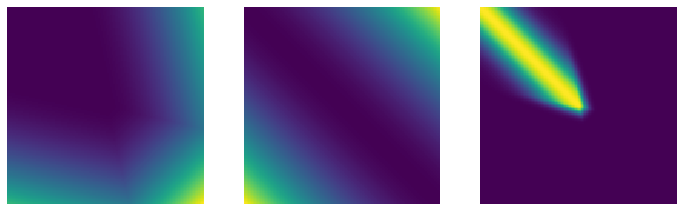

In [192]:
mA         = 3
sigmaXbend = 1
sigmaYbend = 1
# mA         = 3
# sigmaXbend = 1
# sigmaYbend = 1

# tmpgaussPartA = np.exp(-0.5*(kA)**2*((xRotBendL/sigmaXbend)**2 + (yRotBendL/(mA*sigmaYbend))**2))

term1 = (xRotBendL/sigmaXbend)**2
# term1 = (xRotBendL/sigmaXbend)**2
term2 = (yRotBendL/(mA*sigmaYbend))**2
tmpgaussPartA = np.exp(-0.5*(kA)**2*(term1 + term2))
# tmpgaussPartA = np.abs(xRotBendL + yRotBendL)


plt.figure(figsize=(12,4));
plt.subplot(1,3,1)
plt.pcolormesh(term1)
plt.axis('off')
plt.axis('square')
plt.gca().invert_yaxis()
plt.subplot(1,3,2)
plt.pcolormesh(term2)
plt.axis('off')
plt.axis('square')
plt.gca().invert_yaxis()
plt.subplot(1,3,3)
plt.pcolormesh(tmpgaussPartA)
plt.axis('off')
plt.axis('square')
plt.gca().invert_yaxis()

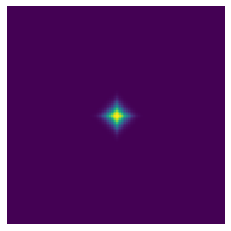

In [159]:
plt.figure();
plt.pcolormesh(tmpgaussPartA)
# plt.pcolormesh(tmpimagteilL)

plt.axis('off')
plt.axis('square')
plt.gca().invert_yaxis()

In [270]:
"""generate a space kernel""" 
preFactorA = kA**2
gaussPartA = tmpgaussPartA
# gaussPartA = np.exp(-0.5*(kA)**2*((xRotBendL/sigmaXbend)**2 + (yRotBendL/(mA*sigmaYbend))**2))
realteilL  = preFactorA*gaussPartA*(np.cos(kA*xRotBendL) - DCPartRealA)
imagteilL  = preFactorA*gaussPartA*(np.sin(kA*xRotBendL) - DCPartImagA)

"""normalize the kernel"""  
normRealL   = np.sqrt(np.sum(realteilL**2))
normImagL   = np.sqrt(np.sum(imagteilL**2))
normFactorL = kA**2

total_std = normRealL + normImagL
if total_std == 0:
    total_std = 10**20
norm_realteilL = realteilL*normFactorL/(0.5*total_std)
norm_imagteilL = imagteilL*normFactorL/(0.5*total_std)

space_kernel = norm_realteilL + norm_imagteilL*1j
freq_kernel = np.fft.ifft2(space_kernel)
       

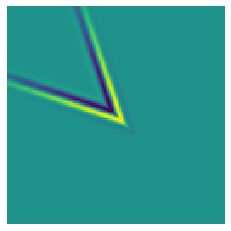

In [273]:
plt.figure();
plt.pcolormesh(np.imag(space_kernel))

plt.axis('off')
plt.axis('square')
plt.gca().invert_yaxis()

[0.3, 0.05, 45.0]


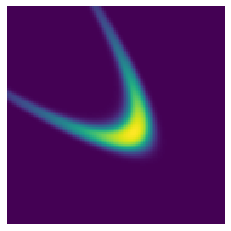

In [22]:
print([kA, bA, alphaA*180/np.pi])

plt.figure();
plt.pcolormesh(np.abs(space_kernel))

plt.axis('off')
plt.axis('square')
plt.gca().invert_yaxis()